In [1]:
import pandas as pd
train=pd.read_csv('IndoreHP_Train.csv')
test=pd.read_csv('IndoreHP_Test.csv')

X=train.drop(columns=['MEDV'])
y=train['MEDV']

In [3]:
# changing the names
X.rename(columns = {"nitric oxides concentration":"NOC", "#rooms/dwelling":"RD", 'RIVER_FLG':'RIVER','PTRATIO  ':'PTRATIO'}, inplace = True)
test.rename(columns = {"nitric oxides concentration":"NOC", "#rooms/dwelling":"RD", 'RIVER_FLG':'RIVER','PTRATIO  ':'PTRATIO'}, inplace = True)

In [4]:
X.head()

,ID,CRIM,ZN,INDUS,RIVER,NOC,RD,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,1,0.006130,18.0,2.3562,0,0.51648,6.31200,64.548,4.090000,1,296,15.3,404.8380,4.8804
1,2,0.027037,0.0,6.8579,0,0.48776,6.74205,81.267,5.165784,2,242,17.8,416.7450,9.4142
2,3,0.028109,0.0,6.9286,0,0.45962,7.40055,61.711,4.967100,2,242,17.8,396.7583,4.0703
3,4,0.033341,0.0,2.2454,0,0.44426,7.34790,45.342,6.001578,3,222,18.7,406.4689,2.9400
4,5,0.072502,0.0,2.1800,0,0.47632,7.14700,53.658,5.819712,3,222,18.7,388.9620,5.3833


### FEATURE ANALYSIS

##### Checking presence of outliers with IQR method

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(style='darkgrid')

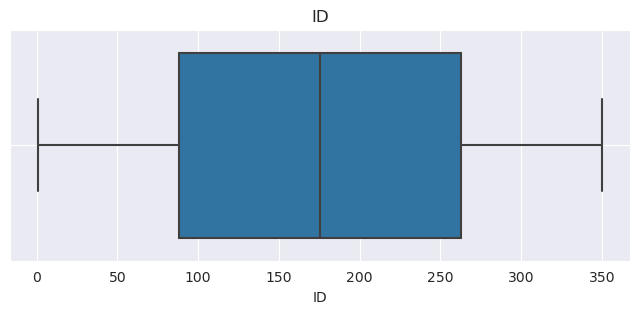

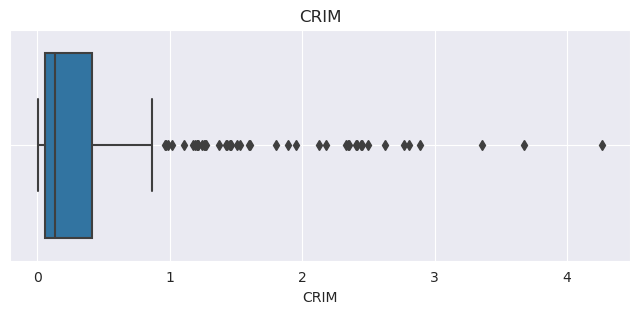

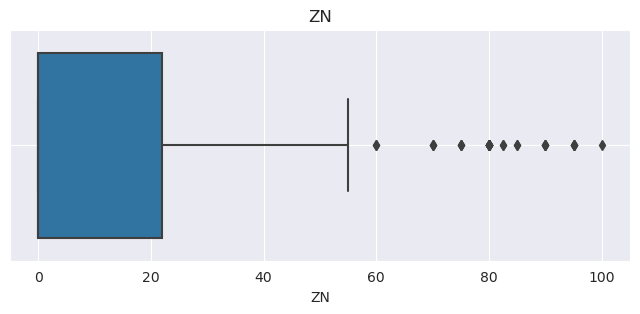

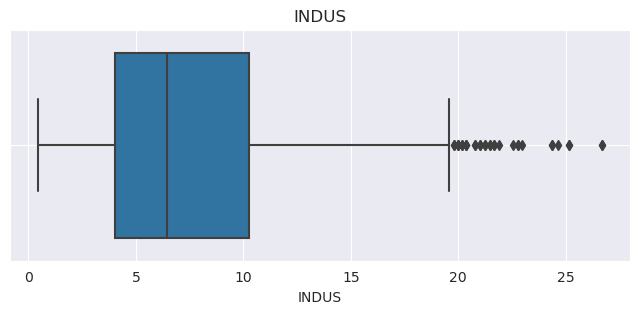

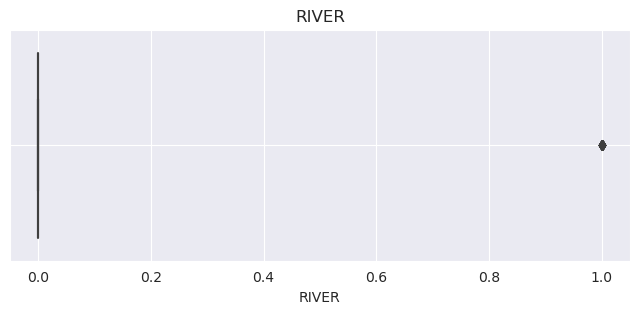

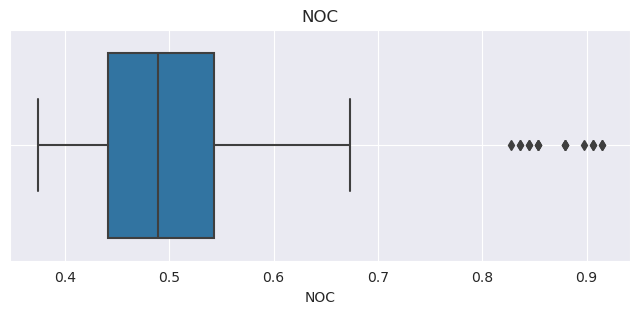

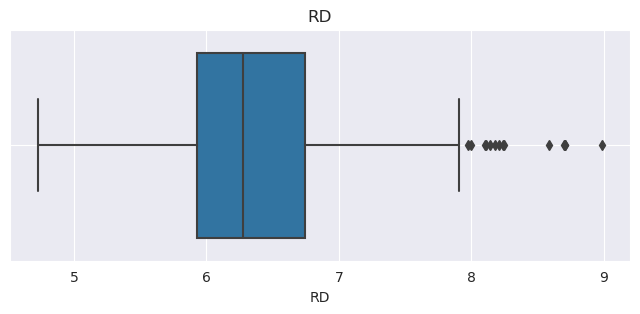

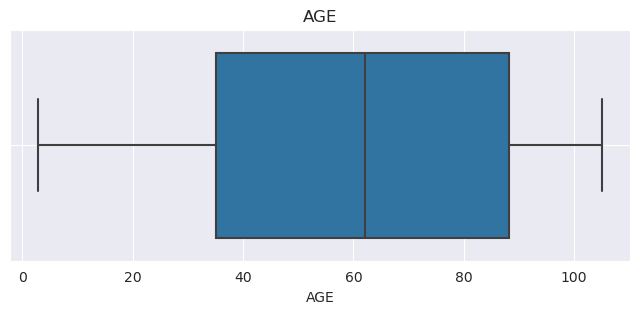

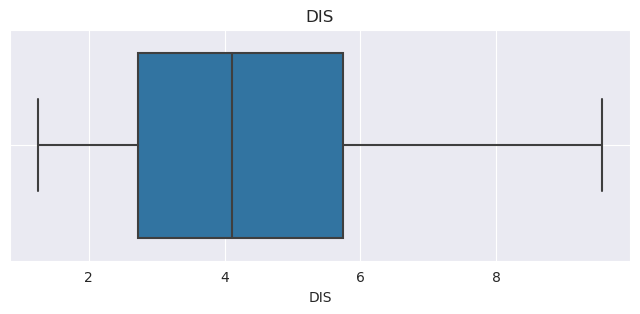

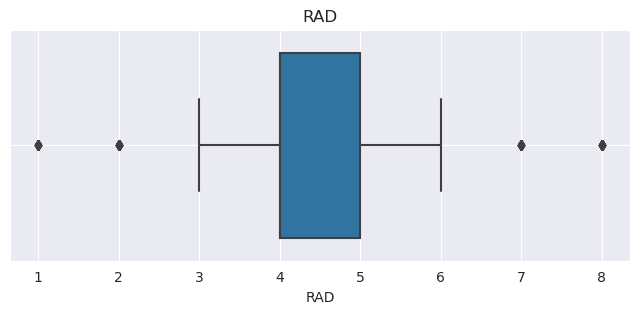

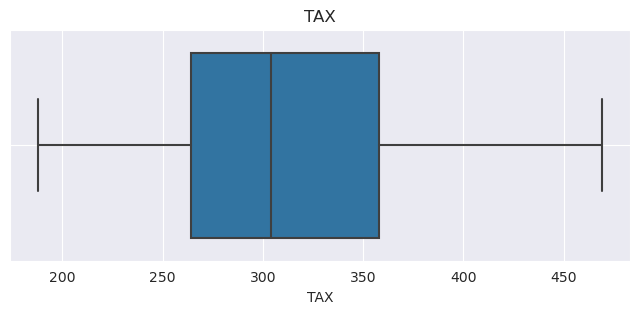

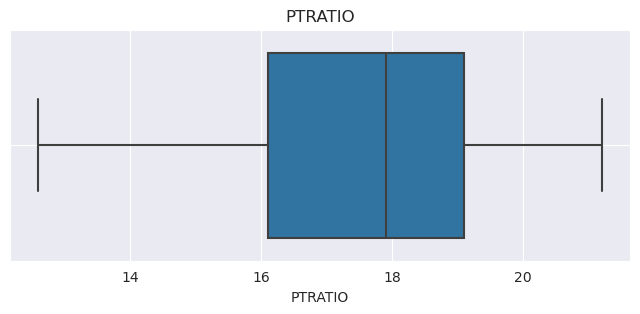

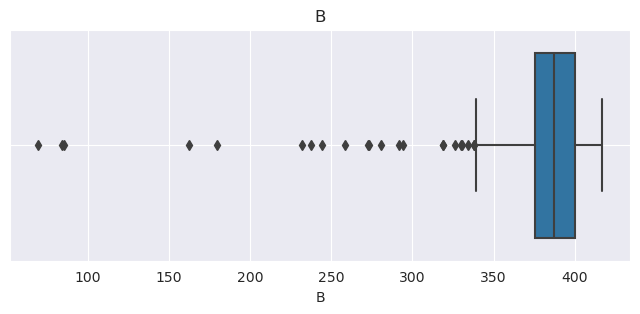

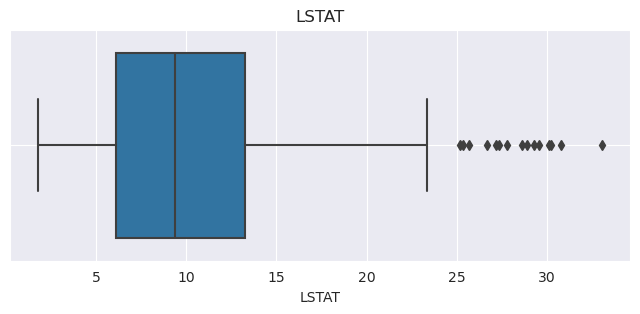

In [8]:
for i in X.columns:
    ax,fig=plt.subplots(figsize=(8,3))
    sns.boxplot(data=X,x=i)
    plt.title(f'{i}')
    plt.grid(True)
    plt.show()

The features with significant outliers are: ['CRIM','ZN','INDUS','NOC','RD','B','LSTAT']

These outliers are not because of wrongful data management. They are because of the way we define outliers.

Let's remove them by using transformations, because I would like to keep the outliers, maybe in different forms.

'ZN' has zero as values. So I will apply cube root on it.

Rest of the other selected features can be tranformer using boxocox

In [9]:
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, PowerTransformer

# Define the transformation to drop the 'ID' column
def drop_column(X):
    return X.drop(columns=['ID'])

# Define the transformation to multiply 'CRIM' by 1000 and 'NOC' by 100
def multiply_transform(X):
    X['CRIM'] = X['CRIM'] * 1000
    X['NOC'] = X['NOC'] * 100
    return X

# Define the transformation for cube root on 'ZN' column
def cube_root_transform(X):
    X['ZN'] = np.cbrt(X['ZN'])
    return X

# Define the transformation for boxcox on selected columns
def boxcox_transform(X):
    columns = ['CRIM','ZN','INDUS','NOC','RD','B','LSTAT']
    X[columns] = PowerTransformer().fit_transform(X[columns])
    return X

# Define the transformation for StandardScaler on selected columns
def minmax_scale(X):
    columns = ['CRIM', 'INDUS', 'ZN', 'NOC', 'RD', 'AGE', 'DIS', 'TAX', 'PTRATIO', 'B', 'LSTAT']
    scaler = MinMaxScaler(feature_range=(0,1))
    X[columns] = scaler.fit_transform(X[columns])
    return X

# Create the ColumnTransformer
ct = ColumnTransformer(
    transformers=[
        ('drop_id', FunctionTransformer(drop_column), ['ID']),
        ('multiply', FunctionTransformer(multiply_transform), ['CRIM', 'NOC']),
        ('cube_root', FunctionTransformer(cube_root_transform), ['ZN']),
        ('boxcox', FunctionTransformer(boxcox_transform), ['CRIM','ZN','INDUS','NOC','RD','B','LSTAT']),
        ('scale', FunctionTransformer(minmax_scale), ['CRIM', 'INDUS', 'ZN', 'NOC', 'RD', 'AGE', 'DIS', 'TAX', 'PTRATIO', 'B', 'LSTAT'])
    ],
    remainder='passthrough'
)


In [10]:
X_transformed=ct.fit_transform(X)
test_transformed=ct.transform(test)

In [15]:
# to analyse the changes I have suggested. Let me convert the ndarray into a dataframe
X_transformed_df=pd.DataFrame(X_transformed)
X_transformed_df.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,6.1304,51.648,2.620741,-1.350816,1.171454,-1.414420,0.374045,0.010306,1.001120,-1.085077,...,0.263174,0.371799,0.603913,0.341521,0.384342,0.313953,0.965722,0.098648,0.0,1.0
1,27.0369,48.776,0.000000,-1.142505,-0.756979,0.025821,0.003840,0.606750,1.854586,0.065612,...,0.210014,0.472802,0.767617,0.471140,0.192171,0.604651,1.000000,0.243802,0.0,2.0
2,28.1087,45.962,0.000000,-1.132299,-0.756979,0.040538,-0.428747,1.356802,0.504087,-1.384863,...,0.157927,0.627459,0.576134,0.447201,0.192171,0.604651,0.942461,0.072711,0.0,2.0
3,33.3411,44.426,0.000000,-1.083105,-0.756979,-1.473014,-0.699287,1.302957,1.109146,-1.896276,...,0.129496,0.615094,0.415856,0.571843,0.120996,0.709302,0.970417,0.036524,0.0,3.0
4,72.5025,47.632,0.000000,-0.745859,-0.756979,-1.508613,-0.162899,1.088340,0.080299,-0.919351,...,0.188839,0.567910,0.497283,0.549930,0.120996,0.709302,0.920017,0.114748,0.0,3.0


In [26]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val=train_test_split(X_transformed,y,\
                                             test_size=0.20,random_state=42)

from sklearn.linear_model import HuberRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from skopt import BayesSearchCV

#model
model1=HuberRegressor()

#parameter space
param_space={
    'epsilon':(1.0,4.0), #epsilon values
    'alpha':(0.01,1.0),
    'max_iter':(100,1000),
}

opt=BayesSearchCV(
    model1,
    param_space,
    n_iter=100,
    cv=5,
    scoring='neg_mean_squared_error'
)

In [27]:
# Wrap BayesSearchCV with tqdm
from tqdm import tqdm
with tqdm(total=opt.total_iterations, desc='Optimizing') as pbar:
    def callback(res):
        pbar.update(1)

    opt.fit(X_train, y_train, callback=callback)

Optimizing:   0%|          | 0/300 [00:00<?, ?it/s]/home/ogre/miniconda3/envs/py39/lib/python3.9/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ogre/miniconda3/envs/py39/lib/python3.9/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/ogre/miniconda3/envs/py39/lib/python3.9/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs faile

In [22]:
from sklearn.metrics import r2_score

In [29]:
# Get the best hyperparameters found by BayesSearchCV
best_params = opt.best_params_
print("Best Hyperparameters:", best_params)

# Evaluate the model with the best hyperparameters on the validation set
best_model = opt.best_estimator_
y_pred = best_model.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)

# Print results
print("Mean Squared Error:", mse)
print("R^2 Score:", r2)
print("MAE:", mae)

Best Hyperparameters: OrderedDict([('alpha', 0.01), ('epsilon', 2.820751612434156), ('max_iter', 1000)])
Mean Squared Error: 11.18799256260211
R^2 Score: 0.8477717378202049
MAE: 2.5518078882252953


In [30]:
y_pred_test=best_model.predict(test_transformed)
submission=pd.read_csv('IndoreHP_Sample.csv')
submission['MEDV']=y_pred1
submission.head()

,ID,MEDV
0,400,33.215953
1,401,31.783780
2,402,39.911251
3,403,32.543613
4,404,38.021601


In [31]:
submission.to_csv('./submission5.csv', index=False)